## **Setting Things Up**

**1 If you haven't already, please hit :**

`File > Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**


**2 In order to use a GPU with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then set the hardware accelerator dropdown to GPU. This can significantly speed up the training process.**

**3 In order to have enough memory with your notebook, select :**

`Runtime > Change runtime type`

**menu, and then select High-RAM in the Runtime shape dropdown.**

To facilitate your initial progress, we have included a ready-to-use code on Google Colab for this problem. It allows you to get started immediately. Additionally, if you prefer not to use Google Colab and prefer setting up your own programming environment or employing alternative methods, the provided files and code will still be valuable.

In [ ]:
# Installing the transformers library and additional libraries if looking process

!pip install -q transformers

# Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.4 MB/s eta 0:00:00


**Here is the PyTorch code used to obtain the text model. We utilized the same pre-trained BERT model weights that were previously implemented in TensorFlow. The SHAP analysis was conducted using this PyTorch version.**

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import time
import datetime

import random

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change to your personal project address

%cd /content/drive/MyDrive/Colab Notebooks/Vehicle Rating Prediction

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/shap


## **1 Data Processing**

In [ ]:
var = "total score"
# var = "safety score"
# var = "performance score"
# var = "interior score"
# var = "critics score"

<class 'list'>
224
32
[32, 36, 38, 39, 41, 41, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5

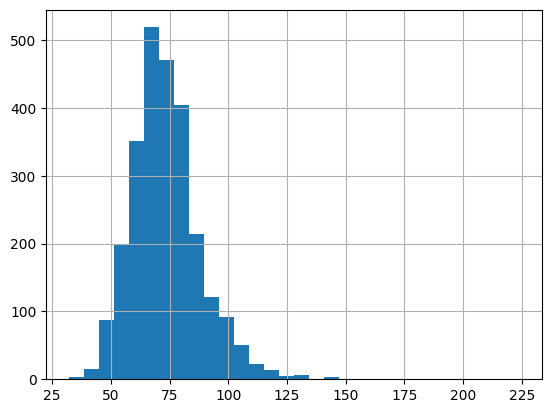

In [ ]:
# load the text data
var_name = 'data split ' + var

sketch1 = pd.read_csv('text_data.csv', encoding='latin1')
# print(sketch1.shape)
# print(sketch1)
# print(sketch1[var])
train_df = sketch1[sketch1[var_name] == 1]
val_df = sketch1[sketch1[var_name] == 2]
test_df = sketch1[sketch1[var_name] == 3]
# print(train_df.shape)
# print(train_df)


sketch2 = sketch1.astype({"text": str})
text1 = list(sketch2['text'])

train_text = [text1[i] for i in train_df.index]
val_text = [text1[i] for i in val_df.index]
test_text = [text1[i] for i in test_df.index]

text = [text1[i] for i in sketch1.index]

y_value = var
y_train = train_df[y_value]
y_val = val_df[y_value]
y_test = test_df[y_value]

# check the length of the each text data (the number of the words in each text data)
seq_len = [len(i.split()) for i in text]
pd.Series(seq_len).hist(bins=30)

print(type(seq_len))
print(max(seq_len))
print(min(seq_len))
seq_len.sort()
print(seq_len)
print(len(seq_len))
print(sum(seq_len)/len(seq_len))

Tokenizer

In [ ]:
# convert the text data by tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(train_text, max_length=128, padding='max_length', truncation=True)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(val_text, max_length=128, padding='max_length', truncation=True)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(test_text, max_length=128, padding='max_length', truncation=True)

In [ ]:
# convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_type_id = torch.tensor(tokens_train['token_type_ids'])
train_y = torch.FloatTensor(y_train)
# print(train_y)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_type_id = torch.tensor(tokens_val['token_type_ids'])
val_y = torch.FloatTensor(y_val.to_numpy())
# print(val_y)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_type_id = torch.tensor(tokens_test['token_type_ids'])
test_y = torch.FloatTensor(y_test.to_numpy())

data preparation

In [ ]:
# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_type_id, train_y)
# dataLoader for train set
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_type_id, val_y)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(test_seq, test_mask, test_type_id, test_y)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [ ]:
print(train_dataloader)
print(train_dataloader.dataset)

In [ ]:
# Bert model
pretrained_model = transformers.BertModel.from_pretrained('google/bert_uncased_L-4_H-512_A-8')


Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
print(pretrained_model)

## **2 Bert model**

In [ ]:
class BERTClass(nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.pretrained_model = transformers.BertModel.from_pretrained('google/bert_uncased_L-4_H-512_A-8')
        self.drop = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.dense = nn.Linear(512, 100)
        self.out = nn.Linear(100, 1)

    def forward(self, ids, mask, token_type_ids):
        output = self.pretrained_model(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output1 = output["pooler_output"]
        # print(output1)
        # print(output1.shape)
        x = self.drop(output1)
        x = self.dense(x)
        x = self.relu(x)
        x = self.out(x)
        x = self.relu(x)
        # print(x)
        return x

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-512_A-8 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (pretrained_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwi

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training Process (contains validation process)

In [ ]:
model.train()

# Training with Validation
epochs = 150
min_valid_loss = np.inf

# Set the seed value all over the place to make this reproducible.
seed_val = 200

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []
best_val_loss = 10

# Measure the total training time for the whole run.
total_t0 = time.time()
count = 0
patience = 20

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        # print(step)
        if step % 1 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains four pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: token_type_ids
        #   [3]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)
        # print(b_labels)

        model.zero_grad()

        # inputs = {'input_ids': b_input_ids, 'attention_mask': b_input_mask}
        # print('already get the input')
        result = model(b_input_ids, b_input_mask, b_token_type_ids)
        # print(result)
        result = torch.squeeze(result, dim=1)

        # print(result)
        # print('great')

        loss = loss_fn(result, b_labels)
        # print(loss)

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Move logits and labels to CPU
        label_ids = b_labels.to('cpu').numpy()

        optimizer.step()

        # Update the learning rate.
        # scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_loss = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: token_type_ids
        #   [3]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        with torch.no_grad():
            result = model(b_input_ids, b_input_mask, b_token_type_ids)
        # print(result)
        result = torch.squeeze(result, dim=1)

        # print(result)
        # print('great')

        loss = loss_fn(result, b_labels)
        # print(loss)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        label_ids = b_labels.to('cpu').numpy()

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.5f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    # save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        count = 0
        PATH = 'model weight/Bert_model_'+var+'.pth'
        torch.save(model.state_dict(), PATH)
    else:
        if count <= patience:
            count = count + 1
        else:
            break


    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 150 ========
Training...
  Batch     1  of     65.    Elapsed: 0:00:00.
  Batch     2  of     65.    Elapsed: 0:00:00.
  Batch     3  of     65.    Elapsed: 0:00:00.
  Batch     4  of     65.    Elapsed: 0:00:00.
  Batch     5  of     65.    Elapsed: 0:00:00.
  Batch     6  of     65.    Elapsed: 0:00:00.
  Batch     7  of     65.    Elapsed: 0:00:00.
  Batch     8  of     65.    Elapsed: 0:00:00.
  Batch     9  of     65.    Elapsed: 0:00:00.
  Batch    10  of     65.    Elapsed: 0:00:00.
  Batch    11  of     65.    Elapsed: 0:00:00.
  Batch    12  of     65.    Elapsed: 0:00:00.
  Batch    13  of     65.    Elapsed: 0:00:00.
  Batch    14  of     65.    Elapsed: 0:00:00.
  Batch    15  of     65.    Elapsed: 0:00:01.
  Batch    16  of     65.    Elapsed: 0:00:01.
  Batch    17  of     65.    Elapsed: 0:00:01.
  Batch    18  of     65.    Elapsed: 0:00:01.
  Batch    19  of     65.    Elapsed: 0:00:01.
  Batch    20  of     65.    Elapsed: 0:00:01.
  Batch    21  

Test Process

In [ ]:
# ========================================
#              Test
# ========================================
# After the completion of training process, measure our performance on our test set.

print("")
print("Running Testing...")

t0 = time.time()

# Put the model in evaluation mode--the dropout layers behave differently during evaluation.
model.eval()

# Tracking variables
total_test_accuracy = 0
total_test_loss = 0
a = 0
# Evaluate data for one epoch
y_test_predict = torch.Tensor([]).to(device)
for batch in test_dataloader:
    if a == 0:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: token_type_ids
        #   [3]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_token_type_ids = batch[2].to(device)
        b_labels = batch[3].to(device)

        with torch.no_grad():
            result = model(b_input_ids, b_input_mask, b_token_type_ids)
        # print(result)
        result = torch.squeeze(result, dim=1)
        # print(result)
        # print(y_test_predict)
        y_test_predict = torch.cat((y_test_predict, result), 0)
        # print(y_test_predict)
        # print(len(y_test_predict))

        # print(result)
        # print('great')

        loss = loss_fn(result, b_labels)
        # print(loss)

        # Accumulate the validation loss.
        total_test_loss += loss.item()

        # Move logits and labels to CPU
        label_ids = b_labels.to('cpu').numpy()

# Calculate the average loss over all of the batches.
avg_test_loss = total_test_loss / len(test_dataloader)

# Measure how long the validation run took.
test_time = format_time(time.time() - t0)
y_test_predict = y_test_predict.to('cpu').numpy()
print(y_test_predict)
print("  Test Loss: {0:.5f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))


Running Testing...
[0.42206347 0.3838408  0.6525438  0.5997831  0.7365882  0.6967804
 0.69650954 0.6783179  0.68321675 0.65668046 0.48460266 0.52819914
 0.6358687  0.77598435 0.26086742 0.6572386  0.5938994  0.62938863
 0.5837897  0.49411753 0.6694862  0.64859515 0.21174793 0.31955883
 0.52068925 0.45877224 0.23506786 0.45443705 0.41694453 0.62246007
 0.4388676  0.76194793 0.66391313 0.6189314  0.379607   0.64164895
 0.6628503  0.59921724 0.65434664 0.41506115 0.5117599  0.7227578
 0.6374729  0.36627755 0.48309466 0.3302663  0.6575988  0.7315542
 0.5010877  0.48901227 0.71337456 0.57657564 0.5033478  0.47372645
 0.6481081  0.7133134  0.5819495  0.4451399  0.44068846 0.7429359
 0.53393763 0.41014513 0.52483517 0.47351512 0.6604127  0.6191477
 0.7015062  0.5373209  0.6577245  0.7166684  0.7367616  0.69690365
 0.37219447 0.6604282  0.76172686 0.63948524 0.7859944  0.68442804
 0.5685673  0.45640305 0.54570216 0.76067024 0.6117441  0.6768002
 0.6074836  0.6213113  0.66908544 0.6115548  0.6

In [ ]:
from math import nan
test = np.array(test_y).T
# print(test)
predict = np.array(y_test_predict).T
# print(predict)

correlation_matrix = np.corrcoef(test, predict)
# print(correlation_matrix)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy ** 2
##range: 0.8199158648859902

print(r_squared)

0.6722128122612661


## **Load the best trained model**

In [ ]:
checkpoint = torch.load('model weight/Bert_model_'+var+'.pth')

In [ ]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

## **Text SHAP Analysis**

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 12.0 MB/s eta 0:00:00


In [ ]:
import shap

do segmentation

In [ ]:
def f(x):
    tv = tokenizer.batch_encode_plus(x, max_length=128, padding='max_length', truncation=True)
    # tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).cuda()
    # print(tv)
    tv_seq = torch.tensor(tv['input_ids']).to(device)
    tv_mask = torch.tensor(tv['attention_mask']).to(device)
    tv_type_id = torch.tensor(tv['token_type_ids']).to(device)
    # attention_mask = (tv!=0).type(torch.int64).cuda()
    outputs = model(tv_seq, tv_mask, tv_type_id).detach().cpu().numpy()
    return outputs

In [ ]:
explainer = shap.Explainer(f, tokenizer)

In [ ]:
print(len(val_text))

258


In [ ]:
print(len(test_text))

258


In [ ]:
total_num = len(val_text) + len(test_text)

In [ ]:
segmentation_value = np.zeros((total_num,4))

In [ ]:
for i in range(len(val_text)):
  shap_values = explainer(val_text[i:(i+1)])
  SHAP_value = np.abs(shap_values.values[0])
  origin_data = shap_values.data[0]
  len_review = 0
  len_pros = 0
  len_cons = 0
  len_new = 0

  for j in range(len(origin_data)-1):
    # print(origin_data[j])
    if origin_data[j] == ' advantages':
      len_review = j
    if origin_data[j] == ' short' and origin_data[j+1] == 'coming':
      len_pros = j-1 - len_review
    if origin_data[j] == ' new' and origin_data[j+1] == ' product':
      len_cons = j - len_pros - len_review
  len_new = len(origin_data) - len_cons - len_pros - len_review
  # print(len_review)
  # print(len_pros)
  # print(len_cons)
  # print(len_new)
  # print(' ')

  for k in range(len(origin_data)):
    if k <= len_review-1:
      segmentation_value[i, 0] = segmentation_value[i, 0] + SHAP_value[k]
    elif k <= len_review+len_pros-1:
      segmentation_value[i, 1] = segmentation_value[i, 1] + SHAP_value[k]
    elif k <= len_review+len_pros+len_cons-1:
      segmentation_value[i, 2] = segmentation_value[i, 2] + SHAP_value[k]
    else:
      segmentation_value[i, 3] = segmentation_value[i, 3] + SHAP_value[k]
  print(segmentation_value[i, :])
  # segmentation_value[i, 0] = segmentation_value[i, 0] / len_review
  # segmentation_value[i, 1] = segmentation_value[i, 1] / len_pros
  # segmentation_value[i, 2] = segmentation_value[i, 2] / len_cons
  # segmentation_value[i, 3] = segmentation_value[i, 3] / len_new
  # print(segmentation_value[i, :])



[0.12622247 0.05658931 0.06879026 0.02543021]
[0.16424545 0.03523712 0.08350316 0.00760633]
[0.10425291 0.11056883 0.05830668 0.00327479]
[0.16177599 0.03759637 0.06130336 0.00141583]
[0.162513   0.03114937 0.04403405 0.00712064]
[0.09843627 0.06738255 0.07607394 0.0124815 ]
[0.1777759  0.0793036  0.01310324 0.00318532]
[0.07966469 0.03262662 0.03071875 0.0045765 ]
[0.14527862 0.06299962 0.02894072 0.00452652]
[0.15926699 0.05944982 0.03089479 0.0143332 ]
[0.09939492 0.09325868 0.00845078 0.00016895]
[0.19283127 0.07060057 0.04420219 0.00486628]
[0.10371162 0.06077932 0.04510801 0.03774938]
[0.16551452 0.07984997 0.05221815 0.00252312]
[0.10749319 0.10165368 0.01901256 0.03865131]
[0.18412744 0.02265364 0.02164653 0.01760699]
[0.08628196 0.04579425 0.02226751 0.01175692]
[0.17451412 0.07925741 0.03390038 0.00284751]
[0.20489031 0.05817654 0.00499888 0.02361257]
[0.10015917 0.03657771 0.03033406 0.00542548]
[0.16071848 0.07993922 0.01182089 0.02588305]
[0.11020511 0.06396364 0.02998744 

In [ ]:
for i in range(len(test_text)):
  shap_values = explainer(test_text[i:(i+1)])
  SHAP_value = np.abs(shap_values.values[0])
  origin_data = shap_values.data[0]
  len_review = 0
  len_pros = 0
  len_cons = 0
  len_new = 0

  for j in range(len(origin_data)-1):
    # print(origin_data[j])
    if origin_data[j] == ' advantages':
      len_review = j
    if origin_data[j] == ' short' and origin_data[j+1] == 'coming':
      len_pros = j-1 - len_review
    if origin_data[j] == ' new' and origin_data[j+1] == ' product':
      len_cons = j - len_pros - len_review
  len_new = len(origin_data) - len_cons - len_pros - len_review
  # print(len_review)
  # print(len_pros)
  # print(len_cons)
  # print(len_new)
  # print(' ')

  cur = len(val_text)

  for k in range(len(origin_data)):
    if k <= len_review-1:
      segmentation_value[i+cur, 0] = segmentation_value[i+cur, 0] + SHAP_value[k]
    elif k <= len_review+len_pros-1:
      segmentation_value[i+cur, 1] = segmentation_value[i+cur, 1] + SHAP_value[k]
    elif k <= len_review+len_pros+len_cons-1:
      segmentation_value[i+cur, 2] = segmentation_value[i+cur, 2] + SHAP_value[k]
    else:
      segmentation_value[i+cur, 3] = segmentation_value[i+cur, 3] + SHAP_value[k]
  print(segmentation_value[i+cur, :])

[0.17196285 0.04283623 0.03323147 0.04912571]
[0.1944515  0.02960606 0.02066562 0.00458558]
[0.09569327 0.10487467 0.01016046 0.00496664]
[0.132725   0.06463311 0.01873958 0.00150937]
[0.27142722 0.05791801 0.0178525  0.00513954]
[0.14628347 0.08927407 0.00494166 0.02387945]
[0.15285207 0.04948463 0.0481621  0.00621383]
[0.13732824 0.1073656  0.01445642 0.00406796]
[0.19753548 0.05808157 0.00720857 0.0055132 ]
[0.12042906 0.07481222 0.01189151 0.01256162]
[0.07878746 0.05969432 0.0157011  0.02827725]
[0.12774849 0.05581577 0.03459766 0.00480264]
[0.11043469 0.09053876 0.01265999 0.01664018]
[0.15140209 0.12413945 0.0494107  0.02013622]
[0.12831257 0.05502524 0.11663006 0.01081304]
[0.07607841 0.13714743 0.01270001 0.00184442]
[0.17930817 0.03205519 0.02242193 0.02168135]
[0.13873991 0.06852619 0.01782585 0.00213764]
[0.13389517 0.09001287 0.04372801 0.02949867]
[0.07791985 0.06434211 0.02089906 0.03253471]
[0.09868365 0.10640836 0.01155657 0.04303822]
[0.10717838 0.08259795 0.01958564 

In [ ]:
avg = np.mean(segmentation_value, axis=0, keepdims=True)

In [ ]:
print(avg)

[[0.15235017 0.05869368 0.02920665 0.01660161]]


In [ ]:
import csv

In [ ]:
headers = ['Review', 'Pros', 'Cons', 'New change']

In [ ]:
with open('SHAP/SHAP_Text/'+ var + '_abs all.csv', 'w', newline='') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    f_csv.writerows(segmentation_value)

f.close()

In [ ]:
with open('SHAP/SHAP_Text/'+ var + '_abs avg.csv', 'w', newline='') as f:
    f_csv = csv.writer(f)
    f_csv.writerow(headers)
    f_csv.writerows(avg)

f.close()

**SHAP values of the words in single text data**

In [ ]:
a = test_text[0:1]

In [ ]:
print(a)

['A rich list of features and a blissful ride help the Audi Q3 climb toward the top of our luxury subcompact SUV rankings. Advantages of the car include: Refined ride, High-end tech features, Elegant cabin. The shortcoming of the car include: Some jerky transmission shifts, Subpar cargo capacity. New product changes: Additional standard safety features, MIB 3 infotainment system replaces MMI, Features reshuffled']


In [ ]:
shap_values = explainer(a)

In [ ]:
print(shap_values)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
b = test_text[1:2]

In [ ]:
shap_values = explainer(b)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
c = test_text[2:3]

In [ ]:
shap_values = explainer(c)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
d = test_text[3:4]

In [ ]:
shap_values = explainer(d)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
e = test_text[4:5]

In [ ]:
shap_values = explainer(e)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
e = test_text[5:6]

In [ ]:
shap_values = explainer(e)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
e = test_text[6:7]

In [ ]:
shap_values = explainer(e)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
e = test_text[7:8]

In [ ]:
shap_values = explainer(e)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
e = test_text[8:9]

In [ ]:
shap_values = explainer(e)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
e = test_text[9:10]

In [ ]:
shap_values = explainer(e)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
f = test_text[14:15]

In [ ]:
shap_values = explainer(f)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
f = test_text[16:17]

In [ ]:
shap_values = explainer(f)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
g = test_text[24:25]

In [ ]:
shap_values = explainer(g)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
g = test_text[27:28]

In [ ]:
shap_values = explainer(g)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
g = test_text[53:54]

In [ ]:
shap_values = explainer(g)

In [ ]:
shap.plots.text(shap_values)

In [ ]:
g = test_text[70:71]

In [ ]:
shap_values = explainer(g)

In [ ]:
shap.plots.text(shap_values)